# Transfer Kernel Model Simulation

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal, Bernoulli
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_aggregation import source as src
from mgds.data_modeling.nbfn import drugs as mgds_drugs
# from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from mgds.data_modeling.nbfn import model_mkl05 as mklmodel
from ml.edward import models as ed_models
from ml.tensorflow.utilities import tf_eval
from sklearn.model_selection import train_test_split
SEED = 1
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations'

2017-04-23 07:38:04,395:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


# Load True Covariates

In [690]:
from sklearn.preprocessing import StandardScaler

X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')
target_drugs = list(np.unique(mgds_drugs.GDSC_PAPER_DRUGS + mgds_drugs.DEFAULT_DRUGS))
X_drug, Y_drug = mkl.get_rx_modeling_data(
    drugs=target_drugs, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)

X_drug = pd.DataFrame(StandardScaler().fit_transform(X_drug.values), index=X_drug.index, columns=X_drug.columns)
X_rppa = pd.DataFrame(StandardScaler().fit_transform(X_rppa.values), index=X_rppa.index, columns=X_rppa.columns)

2017-04-23 10:49:03,191:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-23 10:49:34,078:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-23 10:49:40,844:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107
2017-04-23 10:49:40,862:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-23 10:50:05,500:INFO:mgds.data_modeling.nbfn.mkl: Removing 37 drugs of 233 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


In [691]:
assert np.all(X_drug.notnull())
assert np.all(X_rppa.notnull())

In [692]:
X_rppa, X_rppa_test, Y_rppa, Y_rppa_test = train_test_split(X_rppa, Y_rppa, test_size=.15)

In [693]:
X_drug.shape, X_rppa.shape, X_rppa_test.shape

((46, 13415), (342, 13415), (61, 13415))

In [694]:
Y_drug.shape, Y_rppa.shape, Y_rppa_test.shape

((46, 196), (342, 169), (61, 169))

# Configuration

In [777]:
# Actual Config
P = X_drug.shape[1]

Nr = X_rppa.shape[0]
Nd = X_drug.shape[0]
Nr_test = X_rppa_test.shape[0]

Tr = Y_rppa.shape[1]
Td = Y_drug.shape[1]
#Td = 15

# p_rppa = 50
# p_drug = 5
p_rppa = 500
p_drug = 10
sim_type = 'actual'

w_rppa_sigma = 1.
w_drug_sigma = 1.
#y_sigma = .1
y_sigma = .1

def plot_file(filename):
    return os.path.join(RES_DIR, sim_type, filename)

# Simulation

In [778]:
def run(T):
    return tf_eval(T)

# def get_rppa_covariates():
#     X = Normal(mu=1.*np.zeros([Nr, P]), sigma=1.*np.ones([Nr, P]))
#     return run(X)

# def get_drug_covariates():
#     X = Normal(mu=1.*np.zeros([Nd, P]), sigma=1.*np.ones([Nd, P]))
#     return run(X)

def get_rppa_weights():
    p = p_rppa
    assert P >= p
    p = float(p)/P
    selector = tf.cast(Bernoulli(p=p*np.ones([P, Tr])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([P, Tr]), sigma=w_rppa_sigma * tf.ones([P, Tr]))
    return run(weight * selector) # P x Tr

def get_drug_weights():
    p = p_drug
    assert Tr >= p
    p = float(p)/Tr
    selector = tf.cast(Bernoulli(p=p*np.ones([Tr, Td])), dtype=tf.float32)
    weight = Normal(mu=tf.zeros([Tr, Td]), sigma=w_drug_sigma * tf.ones([Tr, Td]))
    #weight_stretch = w_drug_sigma * tf.nn.tanh(100.* weight)
    W = run(weight * selector) # Tr x Td
    # Make the 10th rppa feature important to all drugs
    W[9, :] = w_drug_sigma * 3
    return W


def get_drug_response(Xd, Wd, Wr):
    # Xd = Nd x P
    # Wd = Tr x Td
    # Wr = P x Tr
    Yr = np.matmul(Xd, Wr) # Nd x Tr
    Yd = np.matmul(Yr, Wd) # Nd x Td
    Y = Normal(mu=tf.constant(Yd), sigma=y_sigma * tf.ones_like(Yd))
    return run(Y) # Nd x Td

def get_rppa_response(Xr, Wr):
    # Xr = Nr x P
    # Wr = P x Tr
    Yr = np.matmul(Xr, Wr) # Nr x Tr
    Y = Normal(mu=tf.constant(Yr), sigma=y_sigma * tf.ones_like(Yr))
    return run(Y) # Nr x Tr
    

def get_simulation_data():
    Xd = X_drug.values
    Xr = X_rppa.values
    Xr_test = X_rppa_test.values
    
    Wd = get_drug_weights()
    Wr = get_rppa_weights()
    
    Yd = get_drug_response(Xd, Wd, Wr)
    Yr = get_rppa_response(Xr, Wr)
    Yr_test = get_rppa_response(Xr_test, Wr)
    
    #Y = None
        
    return (
        pd.DataFrame(Xd).add_prefix('DX'), pd.DataFrame(Xr).add_prefix('RX'), pd.DataFrame(Xr_test).add_prefix('RXT'), 
        pd.DataFrame(Yd).add_prefix('DY'), pd.DataFrame(Yr).add_prefix('RY'), pd.DataFrame(Yr_test).add_prefix('RYT'),
        Wd, Wr
    )

tf.reset_default_graph()
np.random.seed(SEED)
tf.set_random_seed(SEED)
with tf.device('/cpu:0'):
    sim_data = get_simulation_data()
    Xd, Xr, Xr_test, Yd, Yr, Yr_test, Wd, Wr = sim_data

In [697]:
for a in sim_data:
    print(a.shape)

(46, 13415)
(342, 13415)
(61, 13415)
(46, 196)
(342, 169)
(61, 169)
(169, 196)
(13415, 169)


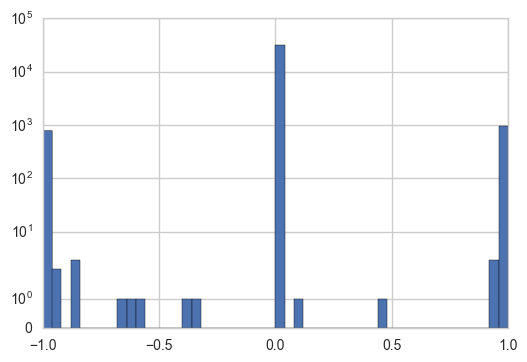

In [179]:
ax = pd.DataFrame(Wd).stack().hist(bins=50)
ax.set_yscale('symlog')

In [145]:
Xd.stack().describe()

count    617090.000000
mean          0.026322
std           1.124626
min         -18.576600
25%          -0.601300
50%          -0.132200
75%           0.587800
max          29.954000
dtype: float64

In [146]:
Xr.stack().describe()

count    4.587930e+06
mean     2.481551e-03
std      9.960046e-01
min     -1.184767e+01
25%     -6.391896e-01
50%     -3.553428e-02
75%      6.072531e-01
max      1.558208e+01
dtype: float64

In [147]:
Yd.stack().describe()

count    9016.000000
mean       -4.763279
std        21.107673
min      -104.007913
25%       -17.631701
50%        -4.248337
75%         9.149713
max        77.497421
dtype: float64

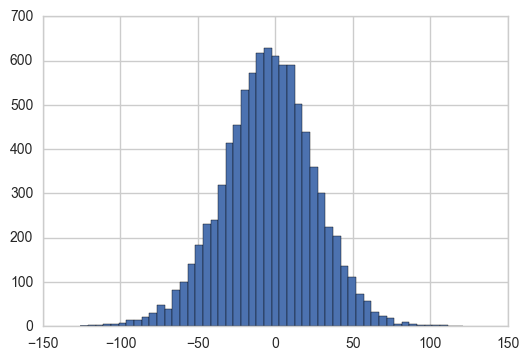

In [180]:
Yd.stack().hist(bins=50)

In [181]:
Yd.describe()

DY0        DY1        DY2        DY3        DY4        DY5  \
count  46.000000  46.000000  46.000000  46.000000  46.000000  46.000000   
mean   13.372213  -9.536920  -4.308993  -6.230766  10.827552  -3.161894   
std    26.187352  26.155453  26.809469  33.510405  22.606578  20.219092   
min   -31.027366 -71.958261 -64.101607 -74.284601 -31.708020 -59.564013   
25%   -10.686789 -27.589199 -27.112335 -29.021219  -7.452082 -16.695859   
50%    11.505397  -7.635589  -0.320239  -6.248271  11.129874  -4.522345   
75%    35.516324  11.798028  15.710090  11.527809  30.374503   9.836319   
max    65.469770  33.169044  47.564532  88.101892  61.759630  54.556742   

              DY6        DY7        DY8        DY9    ...          DY186  \
count   46.000000  46.000000  46.000000  46.000000    ...      46.000000   
mean   -17.397083   0.119261  13.260407  -7.028943    ...     -19.920623   
std     31.068335  13.993781  32.183095  26.440892    ...      29.777113   
min   -106.416674 -32.372646 -74.362375 -54.568348    ...     -75.034656   
25%    -42.961566  -8.515155  -1.042708 -28.549011    ...     -38.984447   
50%    -23.909502   0.438558  14.826781  -2.366460    ...     -25.385751   
75%      3.771268  10.495146  34.871204   8.940124    ...      -6.636378   
max     46.525076  33.929828  75.937072  54.994981    ...      73.061269   

           DY187      DY188      DY189      DY190      DY191      DY192  \
count  46.000000  46.000000  46.000000  46.000000  46.000000  46.000000   
mean    8.588297 -17.759165 -15.569796   6.320189   3.100329  -4.367005   
std    27.808566  25.633715  33.192039  18.102248  23.070172  25.923088   
min   -55.339962 -73.800227 -93.425619 -34.924251 -77.075172 -52.093652   
25%    -3.922417 -33.153714 -41.268820  -4.843685 -11.313916 -22.875454   
50%    11.135757 -18.440575 -21.176669   8.547509   1.251919  -4.441547   
75%    29.092183  -4.072012  12.553176  14.148037  15.561145  10.946457   
max    57.928955  37.993900  47.394672  49.945209  57.249154  49.417395   

           DY193      DY194      DY195  
count  46.000000  46.000000  46.000000  
mean   -3.638971 -11.462596  13.262417  
std    31.434261  29.588153  30.010650  
min   -90.075895 -75.874978 -48.974252  
25%   -15.744927 -27.216773  -5.145693  
50%    -2.601643  -7.695833  11.089520  
75%    19.586863   6.778573  29.156626  
max    52.401705  48.033954  97.928573  

[8 rows x 196 columns]

In [15]:
Yr.stack().describe()

count    57798.000000
mean        -0.142962
std         35.020097
min       -196.945405
25%        -22.504571
50%          0.008121
75%         22.338539
max        170.213752
dtype: float64

In [16]:
Yr_test.stack().describe()

count    10309.000000
mean         0.794669
std         35.532571
min       -189.384113
25%        -21.827468
50%          0.966122
75%         23.528454
max        180.564107
dtype: float64

## Simulation Validation

### RPPA Weights

In [17]:
# RPPA weights should have at least some non-zero entries in columns or there will be no 
# connection to RPPA outputs.  In addition, the mean number of non-zero entries should be p_rppa
Wr.shape 

(13415, 169)

In [18]:
pd.Series((np.abs(Wr) > 0).sum(axis=0)).mean(), p_rppa

(49.437869822485204, 50)

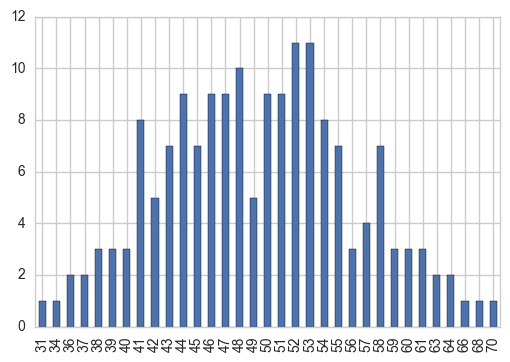

In [19]:
pd.Series((np.abs(Wr) > 0).sum(axis=0)).value_counts().sort_index().plot(kind='bar')

### Drug Weights

In [20]:
# RPPA->Drug weights should have at least some non-zero entries in columns or there will be no 
# connection between Genetic data and drug sensitivity outputs.  
# In addition, the mean number of non-zero entries should be p_drug
Wd.shape

(169, 196)

In [21]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).mean(), p_drug

(11.076530612244898, 10)

In [22]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).value_counts()

9     31
11    22
10    22
13    19
14    18
12    18
8     11
7     11
16     9
15     9
6      7
18     6
17     5
5      5
4      2
3      1
dtype: int64

# Cross Validation

In [23]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [69]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [800]:
def get_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(
        Xr.values, Yr.values, gamma=None, print_kernel_stats=False,
        h_scale=1., w_scale=1.,
        rppa_scale=.1, rx_scale=.3
    )
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=500, random_state=SEED, 
        fail_if_not_converged=False, max_steps=5000,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4simactual/{}'.format(fold_id))
    return est

In [773]:
# ! rm -rf /tmp/mkl4sim/*
# get_mkl_model(0).fit(Xd.values, Yd.values)

In [774]:
# import imp
# imp.reload(trainer)

In [801]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
    
ests = {
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         #('pca', PCA(n_components=.9999)),
#         ('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
#     ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 5, 10)})))
#     ]),
    'pcareg': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]),
    'tkm': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

K = 5
cv = KFold(n_splits=K, random_state=SEED, shuffle=True).split(Xd)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'tkm':
        est = est.fit(X_train.values, Y_train.values)
        est.all_tensors_ = est.get_all_tensors()
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [802]:
! rm -rf /tmp/mkl4simactual/*
train_res = cv_trainer.train_regressors(Xd, Yd, ests, cv)

2017-04-23 11:14:16,400:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-23 11:14:16,482:INFO:ml.model.log: Running model pcareg (Pipeline) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-23 11:14:16,691:INFO:ml.model.log: Running model ridge (Pipeline) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-23 11:14:18,319:INFO:ml.model.log: Running model tkm (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-23 11:14:19,969:INFO:root: On iteration 0 of at most 5000 (loss = 3190900.75, loss change = None)
2017-04-23 11:14:22,109:INFO:root: On iteration 500 of at most 5000 (loss = 807323.625, loss change = -1492.668701171875)
2017-04-23 11:14:24,083:INFO:root: On iteration 1000 of at most 5000 (loss = 413917.625, loss change = -421.5406188964844)
2017-04-23 11:14:26,060:INFO:root: On iteration 1500 of at most 5000 (loss = 272027.0, loss change = -184.28750610351562)
2017-04-23 11:14:28,105:INFO:root: On iteration 2000 of at most 5000 (loss = 206656.640625, loss change = -149.4421844482422)
201

Beginning model refitting


2017-04-23 11:15:35,765:INFO:ml.model.log: Running model ridge (Pipeline) on fold 0 ==> dim(X_train) = (46, 13415), dim(X_test) = (46, 13415), dim(Y_train) = (46, 196), dim(Y_test) = (46, 196)
2017-04-23 11:15:37,637:INFO:ml.model.log: Running model tkm (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (46, 13415), dim(X_test) = (46, 13415), dim(Y_train) = (46, 196), dim(Y_test) = (46, 196)
2017-04-23 11:15:39,315:INFO:root: On iteration 0 of at most 5000 (loss = 3203207.25, loss change = None)
2017-04-23 11:15:41,520:INFO:root: On iteration 500 of at most 5000 (loss = 923137.75, loss change = -1521.6875)
2017-04-23 11:15:43,592:INFO:root: On iteration 1000 of at most 5000 (loss = 502967.375, loss change = -521.296875)
2017-04-23 11:15:45,661:INFO:root: On iteration 1500 of at most 5000 (loss = 340149.53125, loss change = -167.5281219482422)
2017-04-23 11:15:47,728:INFO:root: On iteration 2000 of at most 5000 (loss = 263553.34375, loss change = -65.09687805175781)
2017-04-23 11:15:

In [803]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted Task
Sample                                            
0       -78.462392     1  baseline  -2.878795  DY0
12      -29.664532     1  baseline  -2.878795  DY0
13       47.734863     1  baseline  -2.878795  DY0
14      -95.001312     1  baseline  -2.878795  DY0
16      114.071163     1  baseline  -2.878795  DY0

In [804]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']

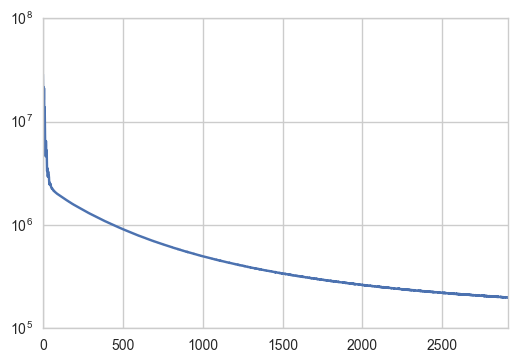

In [805]:
ax = pd.Series(est.clf.losses_[10:]).plot()
ax.set_yscale('symlog')

In [806]:
H = est.clf.get_tensor('qH')
H.shape

(342, 169)

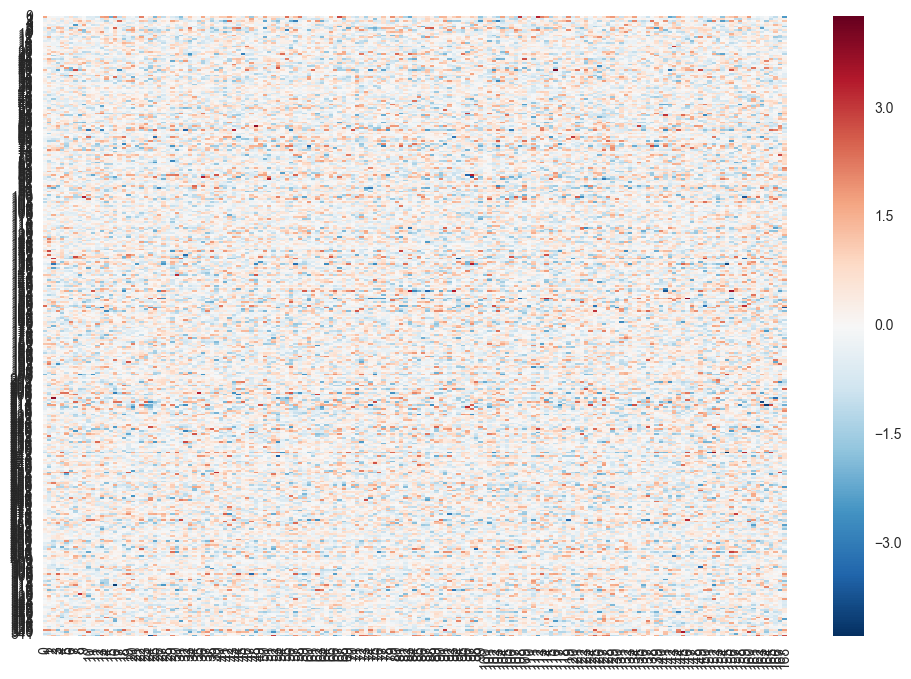

In [807]:
plt.figure(figsize=(12,8))
sns.heatmap(H)

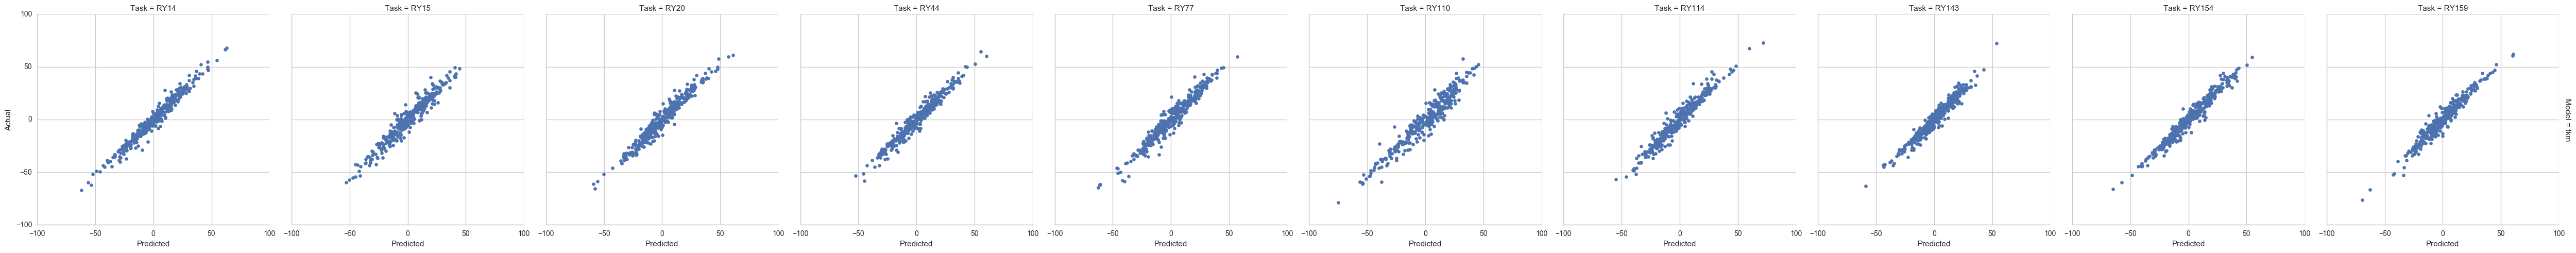

In [808]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.model.y_rppa_scaler.inverse_transform(est.clf.get_tensor('qYR')), index=Yr.index, columns=Yr.columns)
d_pred_train = mkl.stack_predictions(Yp, Yr).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, replace=False, random_state=SEED)
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
#g.savefig(plot_file('pred_train_rppa.png'))

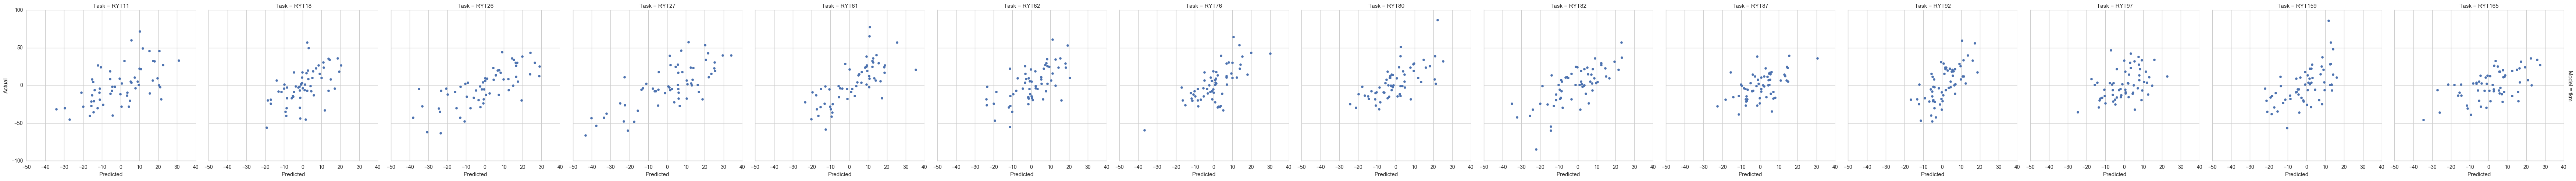

In [809]:
# Predictions on RPPA test data
Yp = pd.DataFrame(est.clf.criticism_args_['pred_rppa_fn'](Xr_test), index=Yr_test.index, columns=Yr_test.columns)
d_pred_rppa = mkl.stack_predictions(Yp, Yr_test).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_rppa['Task'].sample(n=15, replace=False, random_state=SEED)
g = predictions.visualize(train_res, d_pred_rppa[d_pred_rppa['Task'].isin(tasks)], share_axes=True)
# g.savefig(plot_file('pred_train_rppa.png'))

In [810]:
d_pred_rppa.groupby('Task').apply(lambda g: g['Predicted'].corr(g['Actual'])).describe()

count    169.000000
mean       0.649154
std        0.091186
min        0.412525
25%        0.596213
50%        0.653520
75%        0.722815
max        0.862597
dtype: float64

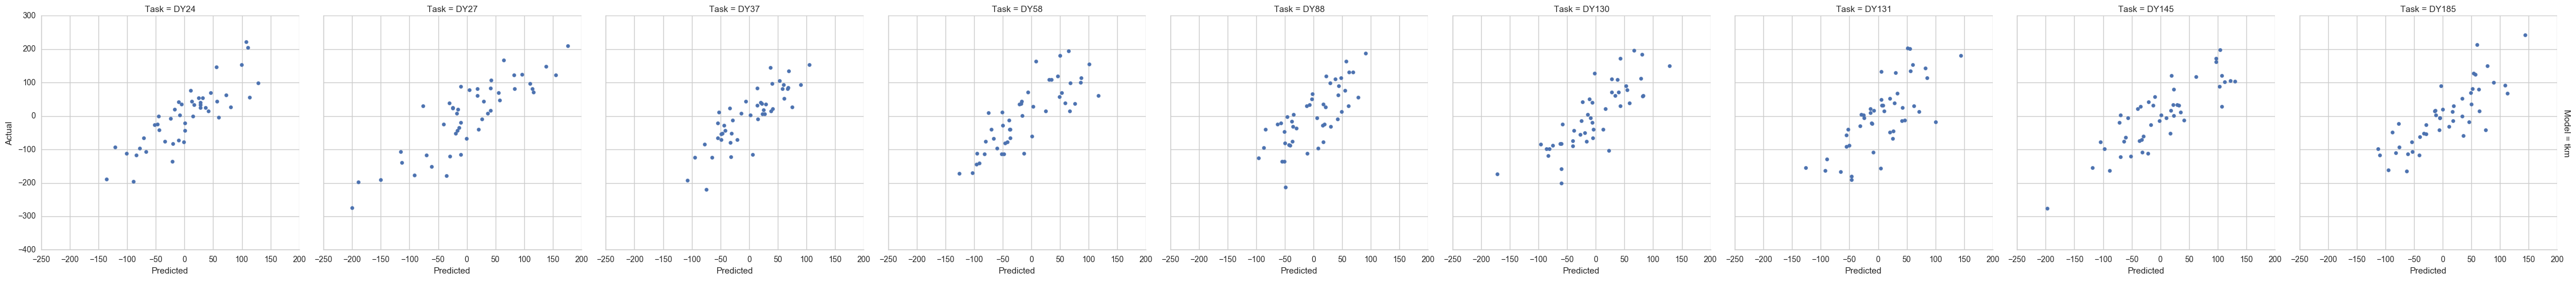

In [811]:
# Predictions on drug training data
Yp = est.clf.predict(Xd.values)
d_pred_train = mkl.stack_predictions(Yp, Yd).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, replace=False, random_state=SEED)
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
#g.savefig(plot_file('pred_train_drug.png'))

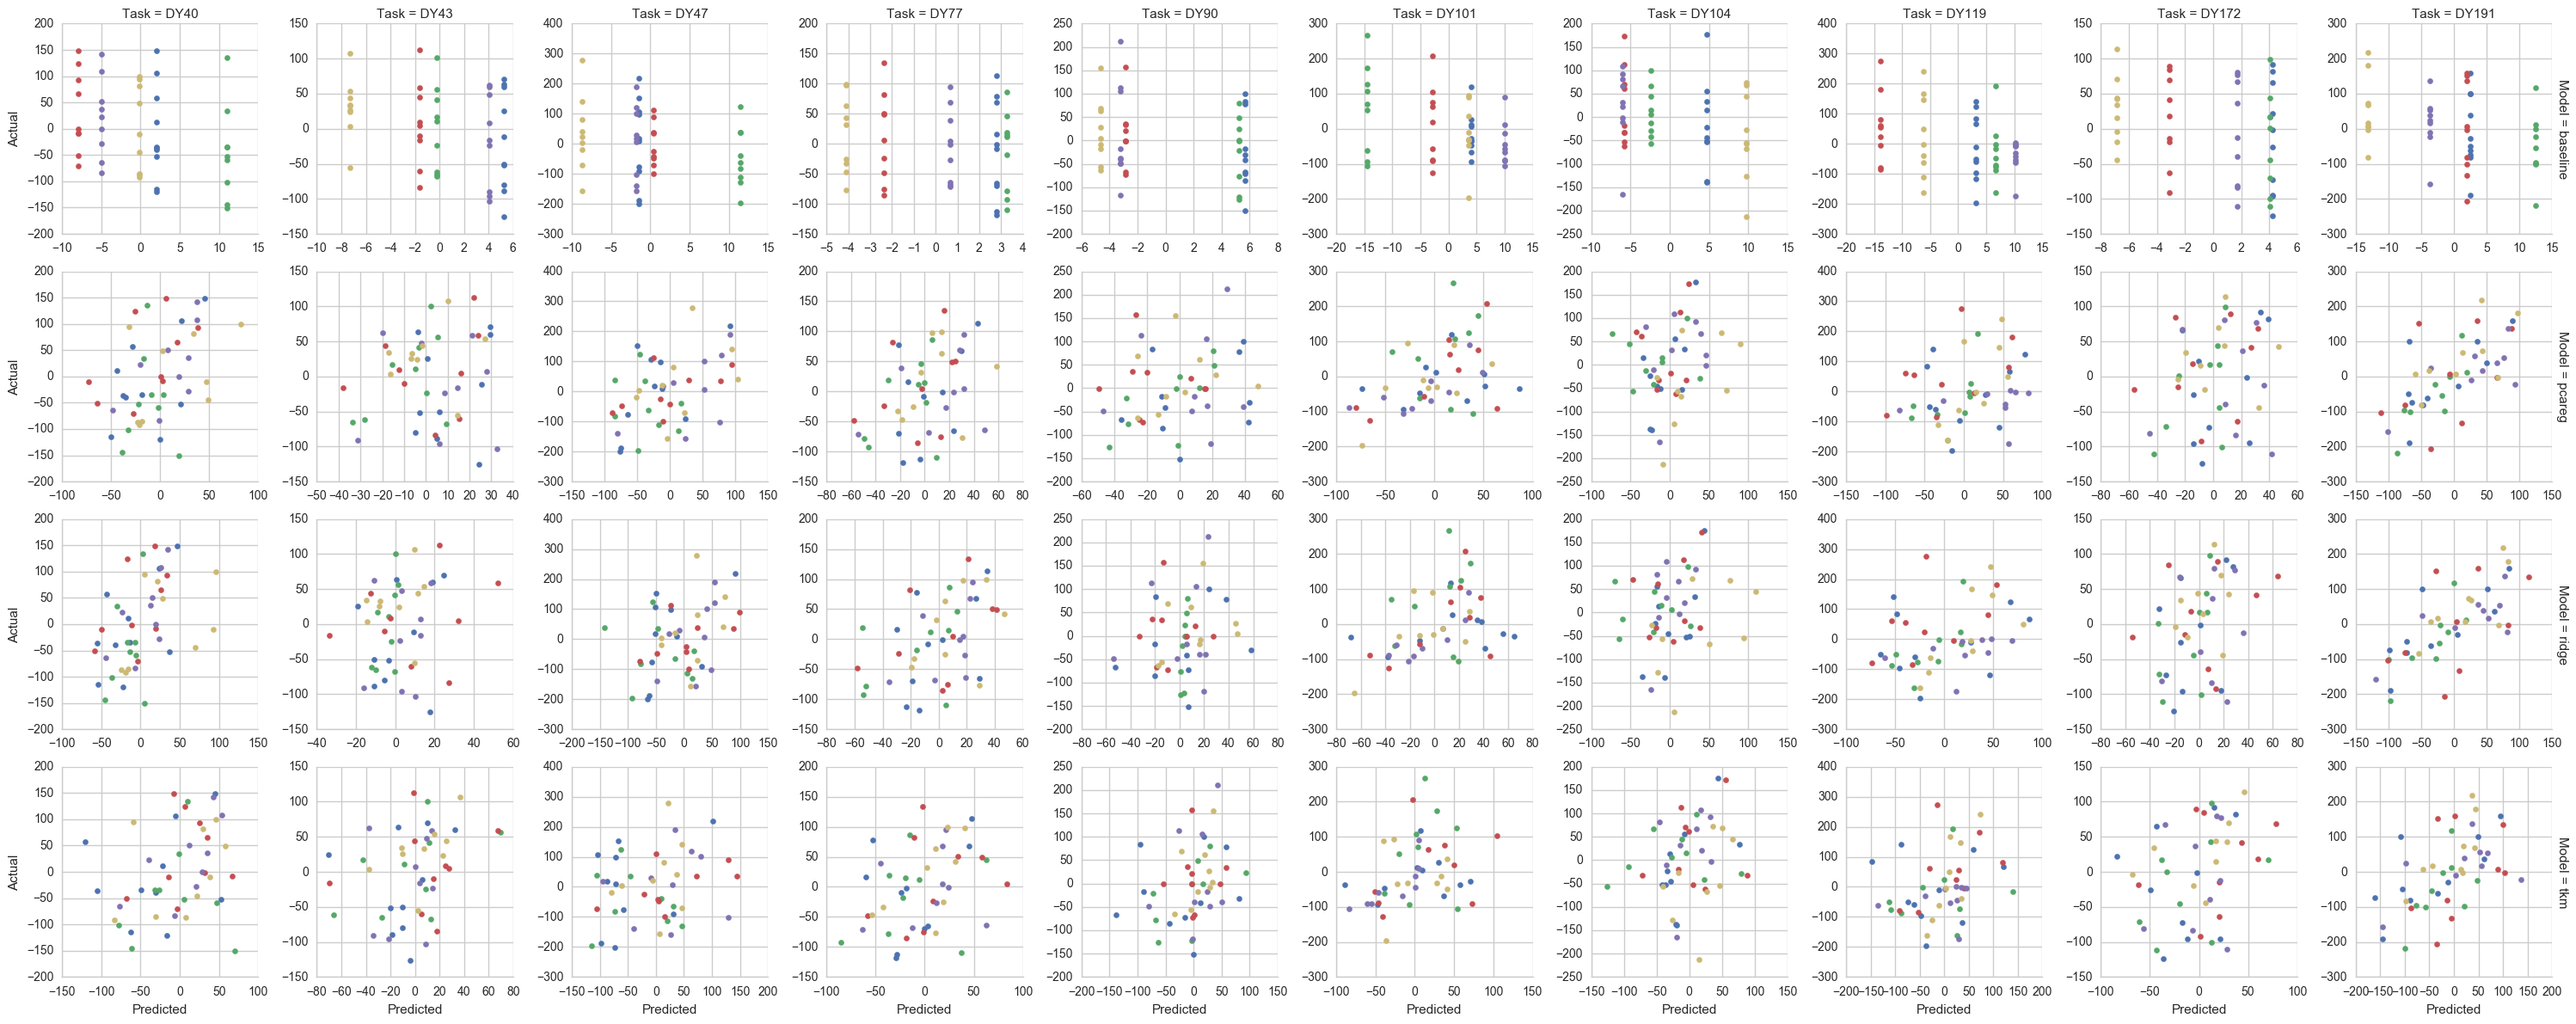

In [812]:
tasks = d_pred_melt['Task'].sample(n=10, random_state=SEED)
g = predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)
#g.savefig(plot_file('pred_sample.png'))

In [813]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearsonp': pearsonr(y_true, y_pred)[1]
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold Task    Metric     Value
0  baseline  All  DY0   pearson -0.241282
1  baseline  All  DY0  pearsonp  0.106228
2  baseline  All  DY0  r2_score -0.032171
3  baseline  All  DY0  spearman -0.193905
4  baseline  All  DY1   pearson -0.334165

In [814]:
def plot_scores(d, metric=None):
    traces = []
    for k, g in d.groupby('Metric'):
        if metric is not None and k != metric:
            continue
        trace = go.Box(x=g['Model'], y=g['Value'], boxmean='sd', boxpoints='all', name=k)
        traces.append(trace)
    layout = go.Layout(boxmode='group', hovermode='closest', title='CV Performance ({} Folds)<br>Metric = {}'.format(K, metric))
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    label = 'all' if metric is None else metric
    filename = plot_file('perf_scores_{}.html'.format(label))
    plty.offline.plt(fig, filename=filename)
    return filename

In [815]:
plot_scores(d_score)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/perf_scores_all.html'

In [356]:
plot_scores(d_score, metric='pearson')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/perf_scores_pearson.html'

In [ ]:
plot_scores(d_score, metric='pearsonp')

# Effects

In [816]:
# Get top performing tasks and ONLY look at weights for those
d_top_score = d_score[(d_score['Model'] == 'tkm') & (d_score['Metric'] == 'pearsonp')].sort_values('Value')
d_top_score = d_top_score[d_top_score['Value'] <= .01]
top_tasks = list(d_top_score['Task'].apply(lambda v: int(v.replace('DY', ''))))
len(top_tasks)

64

### TKL Model

In [817]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']
qW = est.clf.all_tensors_['qW']

In [797]:
qW.shape

(169, 196)

In [326]:
# plt.figure(figsize=(12, 5))
# sns.heatmap(np.where(np.abs(qW) < .15, np.nan, qW)[:25, :25])

In [327]:
# plt.figure(figsize=(12, 5))
# #sns.heatmap(np.where(Wd == 0, np.nan, Wd)[:25, :25])
# sns.heatmap(np.where(np.abs(Wd) < .1, np.nan, Wd)[:25, :25])

In [717]:
def plot_weights(W_true, W_pred):
    x = np.concatenate([np.arange(W_true.shape[1]) for i in range(W_true.shape[0])])
    y = np.concatenate([np.repeat(i, W_true.shape[1]) for i in range(W_true.shape[0])])
    z = W_true.ravel()
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['RPPA {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    for i in range(W_true.shape[0]):
        weights = W_true[i,:]
        trace = go.Scatter(
            x=drugs,
            y=np.repeat(proteins[i], len(weights)),
            mode='markers',
            marker=dict(
                size=np.where(np.abs(weights) > 0, 10, 0),
                color=np.where(weights > 0, 'rgb(31, 119, 180)', 'rgb(214, 39, 40)')
            ),
            text=pd.Series(W_true[i,:]).apply(lambda v: 'Actual Weight: {}'.format(v) if not pd.isnull(v) else np.nan),
            hoverinfo='x+y+text',
            showlegend=False
        )
        traces.append(trace)
    layout = go.Layout(
        height=800, 
        hovermode='closest',
        title='Actual vs Estimated Weight Values<br>(dots=Actual, bars=Estimated)'
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_tkm.html')
    plty.offline.plt(fig, filename=filename)
    return filename

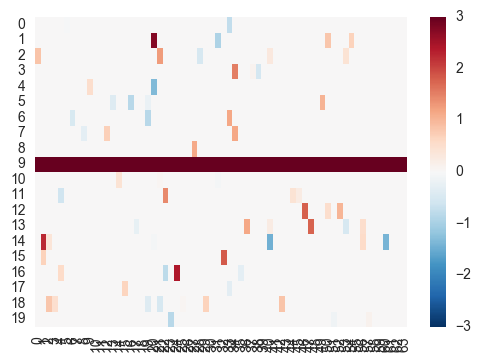

In [818]:
sns.heatmap(Wd[:20,top_tasks])

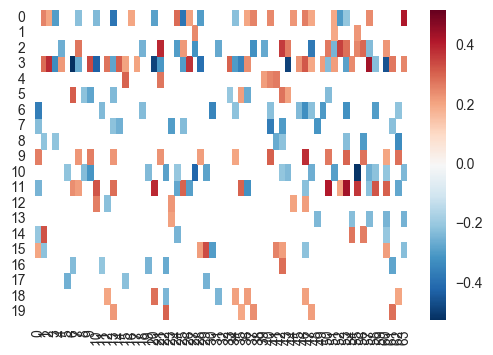

In [821]:
dt = np.where(np.abs(qW) >= .2, qW, np.nan)
sns.heatmap(dt[:20,top_tasks])

In [95]:
weight_thresh = .1
plot_weights(
    np.where(np.abs(Wd) < .5, np.nan, Wd)[:,top_tasks],
    np.where(np.abs(qW) < weight_thresh, np.nan, qW)[:,top_tasks]
)

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning:

invalid value encountered in greater



'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/weight_estimate_tkm.html'

In [724]:
pd.Series(Wd.ravel()).describe()

count    33124.000000
mean         0.016842
std          0.334696
min         -2.958291
25%          0.000000
50%          0.000000
75%          0.000000
max          3.111032
dtype: float64

In [825]:
weight_thresh = .3
qWsparse = np.where(np.abs(qW) < weight_thresh, np.nan, qW).ravel()
Wdsparse = np.where(np.abs(Wd) < .5, np.nan, Wd).ravel()
qWselect = (np.abs(np.nan_to_num(qWsparse)) > 0).astype(np.int64)
Wdselect = (np.abs(np.nan_to_num(Wdsparse)) > 0).astype(np.int64)
rctable = pd.DataFrame({'inferred': Wdselect, 'actual': qWselect}).groupby(['inferred', 'actual']).size().unstack()
rctable

actual        0     1
inferred             
0         30534  1197
1          1307    86

In [826]:
from scipy.stats import fisher_exact, chi2_contingency

fisher_exact(rctable.values), chi2_contingency(rctable.values)

((1.6784654827581578, 2.5103162921673365e-05),
 (20.02764441752749,
  7.6330662828985132e-06,
  1,
  array([[ 30501.95540997,   1229.04459003],
         [  1339.04459003,     53.95540997]])))

## Lasso

In [33]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['lasso']
qW = []
for e in est.clf.named_steps['est'].estimators_:
    qW.append(e.coef_)
qW = pd.DataFrame(qW).T
qW.shape

(600, 25)

In [34]:
def plot_weight_estimates(W_pred, model='Lasso'):
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['Gene {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    layout = go.Layout(
        height=2000, 
        hovermode='closest',
        title='Estimated Weight Values<br>({} Model)'.format(model)
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_{}.html'.format(model.lower()))
    #plty.offline.plt(fig, filename=filename)
    return filename
    
plot_weight_estimates(
    np.where(np.abs(qW) < .001, np.nan, qW)[:,:],
    model='Lasso'
)

# plot_surface(
#     np.array([[1,2], [3,4], [5,6]]),
#     np.array([[1,2], [3,4], [5,6]])
# )

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/large/weight_estimate_lasso.html'

# Parameter Count Estimates

In [368]:
# Counts for simulation (small)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(7620, 4800)

In [334]:
# Counts for simulation (large)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(72332, 15000)

In [335]:
# Counts for actual

# NOTE: * does not need to be rerun based on configuration

# Actual Config
# P = 13415
# Nr = 403
# Nd = 46
# Tr = 169
# Td = 196
# p_rppa = 100
# p_drug = 5

p_tkm = (403 * 169) + (169 * 196)
p_lasso = 13415 * 196
p_tkm, p_lasso

(101231, 2629340)